In [1]:
datasetName = 'eye_AdultOmentum3_Guo2020'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/eye_AdultOmentum3_Guo2020")

In [2]:
library(Seurat)
library(data.table)
library(ggplot2)
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- data.table::fread(paste0(datasetName,"_expression.tsv.gz"), h = T, data.table = F)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}


In [3]:
row.names(data.matrix) <- data.matrix[, 1]
data.matrix <- data.matrix[, -1]
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,AdultOmentum_3.CTCGCAATCTCTTGATCA,AdultOmentum_3.AACCTATGGATGTATTGT,AdultOmentum_3.AGGACTTGCAATTTTAGG,AdultOmentum_3.TCGTAAAAGCGGCCGACG,AdultOmentum_3.GGACATATGCTTTACTTC
,<int>,<int>,<int>,<int>,<int>
A1BG-AS1,0,0,0,0,0
A2M,0,0,0,0,0
A4GALT,0,0,0,0,0
AAAS,0,0,0,0,0
AACS,0,0,0,0,0


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
AdultOmentum_3.CTCGCAATCTCTTGATCA,eye,AdultOmentum,AdultOmentum,normal,Donor32,male,56 years old
AdultOmentum_3.AACCTATGGATGTATTGT,eye,AdultOmentum,AdultOmentum,normal,Donor32,male,56 years old
AdultOmentum_3.AGGACTTGCAATTTTAGG,eye,AdultOmentum,AdultOmentum,normal,Donor32,male,56 years old
AdultOmentum_3.TCGTAAAAGCGGCCGACG,eye,AdultOmentum,AdultOmentum,normal,Donor32,male,56 years old
AdultOmentum_3.GGACATATGCTTTACTTC,eye,AdultOmentum,AdultOmentum,normal,Donor32,male,56 years old


[1] <NA> <NA> <NA> <NA> <NA>
14 Levels: Antigen presenting cell (RPS high) B cell ... T cell

In [4]:
# Pre-processing
min.cells = 3
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


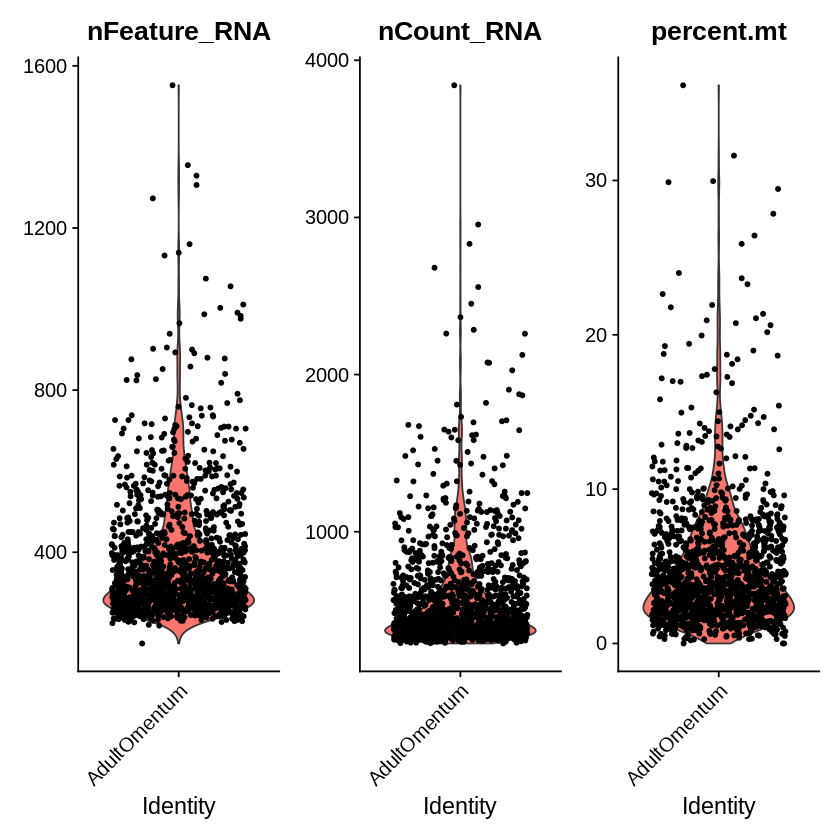

In [5]:
VlnPlot(dataobj, features = c('nFeature_RNA', 'nCount_RNA', 'percent.mt'), ncol = 3)

In [6]:
# QC
nFeature_RNA_range = c(200, 2500)
percent.mt.thre = 5
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)


In [7]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'vst', nfeatures = 2000) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -2.6547”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.30103”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  9.9401e-17”
Centering and scaling data matrix



In [8]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  S100A9, S100A8, S100A11, S100A12, IFITM2, ALOX5AP, SRGN, HLA-C, RGS2, MMP9 
	   G0S2, SOD2, FTH1, ARG1, CXCL8, FCN1, MYL6, SAT1, RGL4, HLA-B 
	   LYZ, FTL, ACTB, IL1B, FCGR3A, B2M, ORM1, MT-RNR2, ALPL, CXCL1 
Negative:  MFAP4, FSTL1, IGFBP6, CFD, MFAP5, SERPING1, ANXA2, CYR61, DCN, ACKR3 
	   GPX3, LUM, EFEMP1, C1R, PRSS23, CD99, MGP, C1S, S100A13, COL1A2 
	   LTBP4, NR4A1, FBLN5, RASD1, SPARC, S100A10, LGALS1, CST3, CCDC80, UAP1 
PC_ 2 
Positive:  MFAP4, DCN, LUM, C1S, C1R, GSN, CCDC80, SERPING1, APOD, MGP 
	   MFAP5, IGFBP6, GPX3, EFEMP1, FBLN5, FSTL1, ACKR3, CLU, S100A8, DPT 
	   ISLR, CD34, CYR61, CFD, ADH1B, HSPB6, LTBP4, NNMT, FBLN2, COL6A2 
Negative:  MT-CO1, HLA-DRB1, CD74, CD52, RPS27, RPS18, HLA-DRA, MT-TW, PTMA, HLA-DPB1 
	   CD83, EEF1A1, GPR183, RPS19, RPL23A, RPL36, RPL13, CD163, RPL18A, RPS24 
	   RPS13, C1QB, LYVE1, RPS14, CCL5, RPS3A, RPL15, RPL3, RPL19, HLA-DPA1 
PC_ 3 
Positive:  RPS27, CCL5, RPS14, RPL13, RPS18, RPS19, RPL23A, RP11-543P15.1, RPL31,

Warning message in ElbowPlot(dataobj, ndims = 100):
“The object only has information for 50 reductions”


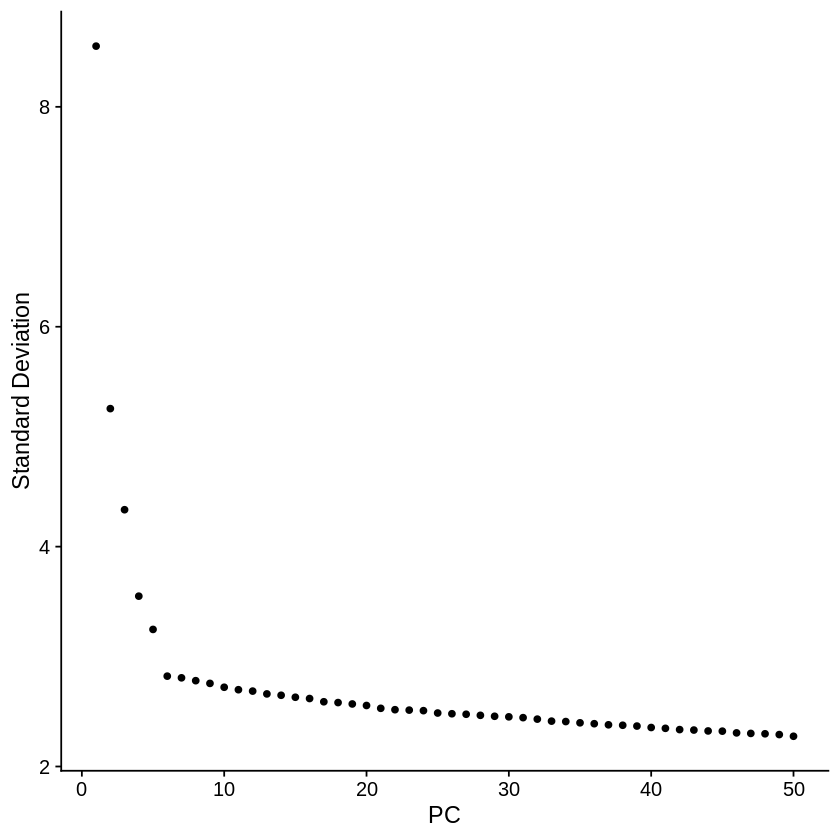

In [9]:
ElbowPlot(dataobj, ndims=100) 
# pdf(paste0(datasetName,"seurat.elbowplot.pdf"))

In [10]:
dev.off()
pcDim = 10 # set as 50 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

null device 
          1

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
20:32:37 UMAP embedding parameters a = 0.9922 b = 1.112

20:32:37 Read 903 rows and found 10 numeric columns

20:32:37 Using Annoy for neighbor search, n_neighbors = 30

20:32:37 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

20:32:37 Writing NN index file to temp file /tmp/RtmpL67Dhp/file7ab41548e363

20:32:37 Searching Annoy index using 1 thread, search_k = 3000

20:32:37 Annoy recall = 100%

20:32:38 Commencing smooth kNN distance calibration using 1 thread

20:32:38 Initializing fro

In [14]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.6)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 903
Number of edges: 33651

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7543
Number of communities: 7
Elapsed time: 0 seconds


20:33:14 UMAP embedding parameters a = 0.9922 b = 1.112

20:33:14 Read 903 rows and found 10 numeric columns

20:33:14 Using Annoy for neighbor search, n_neighbors = 30

20:33:14 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

20:33:15 Writing NN index file to temp file /tmp/RtmpL67Dhp/file7ab4252dadec

20:33:15 Searching Annoy index using 1 thread, search_k = 3000

20:33:15 Annoy recall = 100%

20:33:15 Commencing smooth kNN distance calibration using 1 thread

20:33:16 Initializing from normalized Laplacian + noise

20:33:16 Commencing optimization for 500 epochs, with 39244 positive edges

20:33:18 Optimization finished



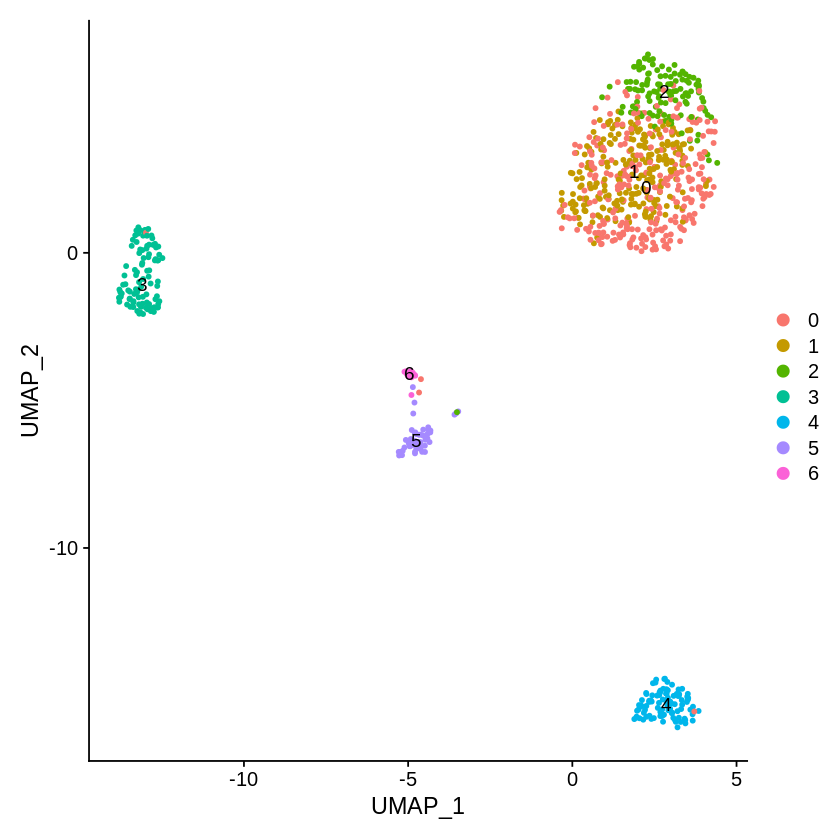

In [15]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [16]:
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

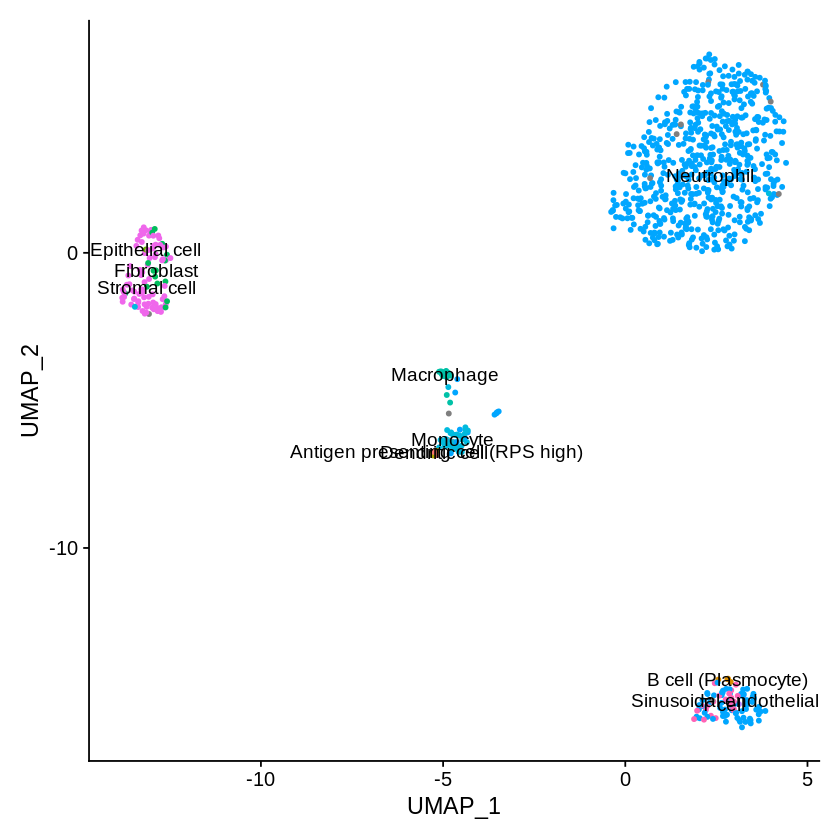

In [17]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1) + NoLegend()
p_umap2

In [18]:
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

In [19]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6



In [19]:
new.cluster.ids <- c('Eye-Connective tissue-Granulocyte-IL1B', 'Eye-Connective tissue-Neutrophil-S100A8', 'Eye-Connective tissue-Neutrophil-S100A8',
                    'Eye-Connective tissue-Stromal cell-FBN1', 'Eye-Connective tissue-T cell-CCL5', 'Eye-Connective tissue-Macrophage/Granulocyte-CD163/IL1B', 
                    'Eye-Connective tissue-Macrophage-CD163')
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

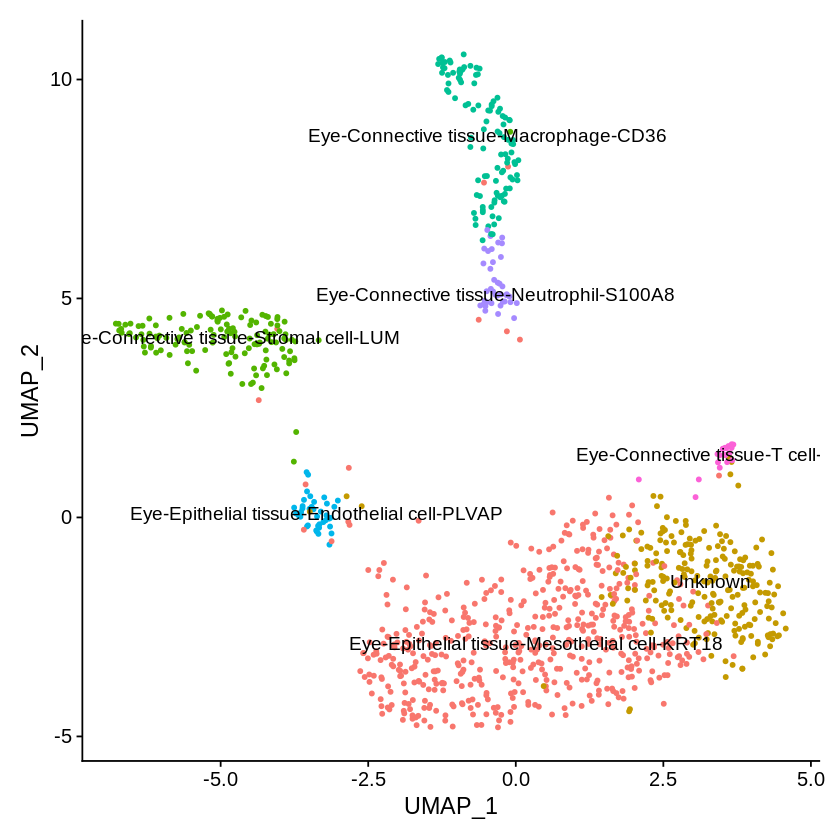

In [20]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE) + NoLegend()
p_umap2

In [21]:
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [22]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))